In [1]:
import json
import os.path as osp
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import seaborn as sns

plt.rcParams['font.family'] = 'DeJavu Serif'

In [2]:
# set to location of data directory
data_dir = ''

In [11]:
query_type_counts = {'query_action': 0 ,'query_direction': 0, 'query_body_part': 0}
filter_type_counts = {'filter_action': 0, 'filter_direction': 0, 'filter_body_part': 0}
query_type_concept_counts = defaultdict(lambda: defaultdict(int))
relation_type_counts = {'after': 0, 'before': 0, 'no relation': 0, 'in between': 0}
babel_ids = []

motion_concepts = json.load(open(osp.join(data_dir, 'motion_concepts.json')))
questions = json.load(open(osp.join(data_dir, 'questions.json')))
    

for _, question in questions.items():
    babel_ids.append(question['babel_id'])
    query_type_counts[question['query_type']] += 1
    query_type_concept_counts[question['query_type']][question['answer']] += 1
    #query_concept_counts[question['answer']] += 1

    for block in question['program']:
        if 'filter' in block['function']:
            filter_type_counts[block['function']] += 1
    
    if len(question['program']) > 4:
        relation_type_counts['in between'] += 1
    else:
        if question['program'][2]['function'] == 'relate':
            relation_type = question['program'][2]['value_inputs'][0]
            relation_type_counts[relation_type] += 1
        else:
            relation_type_counts['no relation'] += 1

seq_lengths = []
num_segments = []
for babel_id in babel_ids:
    seq_lengths.append(motion_concepts[babel_id][-1]['end_f'] / 30)
    num_segments.append(len(motion_concepts[babel_id]))
    
# reorder for pie graph
for query_type, concept_counts in query_type_concept_counts.items():
    query_type_concept_counts[query_type] = dict(sorted(concept_counts.items(), key=lambda x:x[1], reverse=True))

query_concept_counts = {}
query_concepts = []
query_concept_type_indices = []

num_processed_concepts = 0
for query_type in ['query_action', 'query_direction', 'query_body_part']:
    for concept, count in query_type_concept_counts[query_type].items():
        query_concepts.append((concept, query_type))
    query_concept_type_indices.append((num_processed_concepts,len(query_type_concept_counts[query_type]) + num_processed_concepts))
    num_processed_concepts += len(query_type_concept_counts[query_type])
                                      
for concept, query_type in query_concepts:
    query_concept_counts[concept] = query_type_concept_counts[query_type][concept]

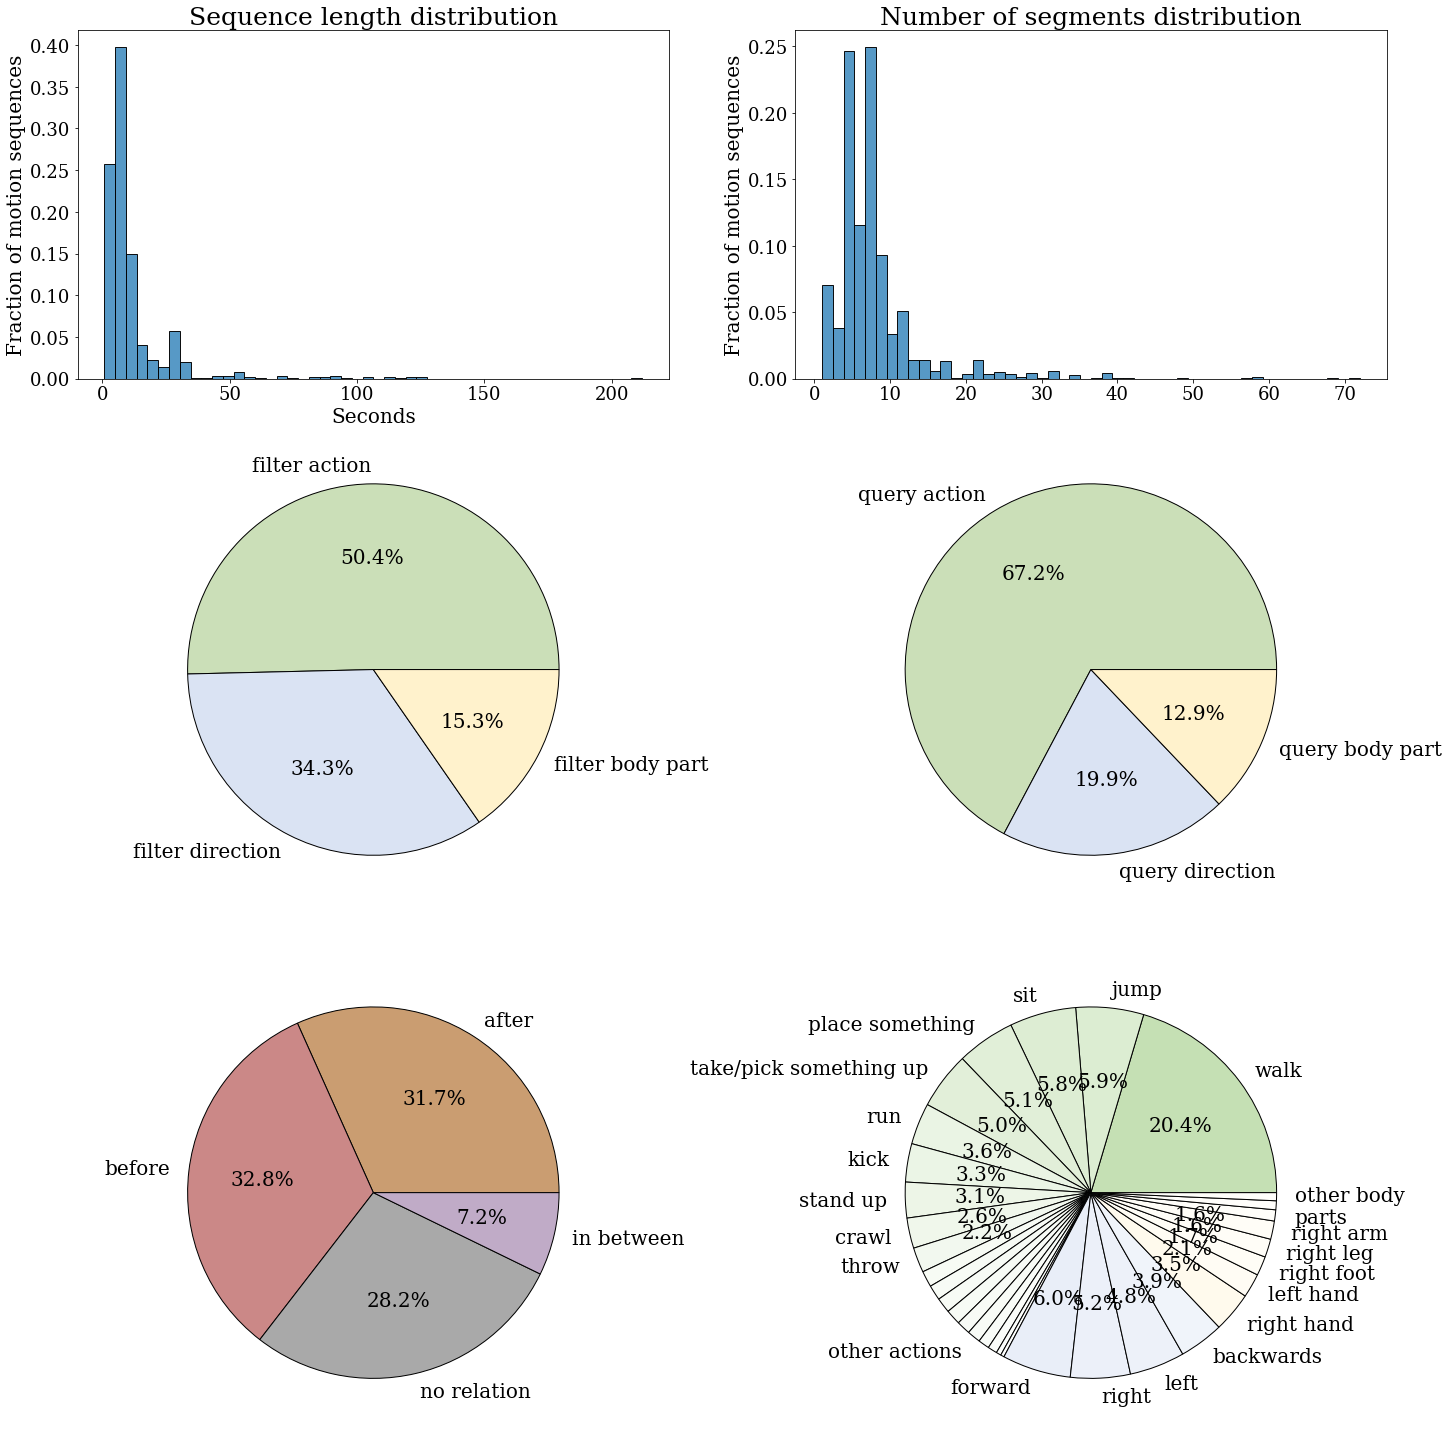

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(20,20), gridspec_kw={'height_ratios': [0.75, 1, 1]})
renamings = {'filter_action': 'filter action',
             'filter_direction': 'filter direction',
             'filter_body_part': 'filter body part',
             'query_action': 'query action',
             'query_direction': 'query direction',
             'query_body_part': 'query body part'}

percentage_threshold = 1.5 # don't print names in pie chart that make up less than this threshold
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > percentage_threshold else ''

def process_labels(labels, sizes):
    total_size = sum(sizes)
    new_labels = []
    for label_i, label in enumerate(labels):
        if label == 'jog': # middle of concepts that are too low percentage to print without overlap
            new_labels.append('other actions')
        elif label == 'left arm':
            new_labels.append('other body \nparts')
        elif sizes[label_i] / total_size < (percentage_threshold / 100):
            new_labels.append('')
        else:
            new_labels.append(label)
    return new_labels

for i, counts in enumerate([seq_lengths, num_segments, filter_type_counts, query_type_counts, relation_type_counts, query_concept_counts]):
    ax = axes[int(i / 2)][i % 2]
    if counts == seq_lengths:
        sns.histplot(seq_lengths, bins=50, stat='probability', ax=ax)
        ax.set_title(f'Sequence length distribution',fontsize=25)
        ax.set_xlabel('Seconds',fontsize=20)
        ax.set_ylabel('Fraction of motion sequences',fontsize=20)
        ax.tick_params(labelsize=18)
    elif counts == num_segments:
        sns.histplot(num_segments, bins=50, stat='probability', ax=ax)
        ax.set_title('Number of segments distribution',fontsize=25)
        ax.set_ylabel('Fraction of motion sequences',fontsize=20)
        ax.tick_params(labelsize=18)
    else:
        pie_labels = []
        pie_sizes = []

        for label, count in counts.items():
            if label in renamings:
                label = renamings[label]
            pie_labels.append(label)
            pie_sizes.append(count)
        
        if counts == filter_type_counts or counts == query_type_counts:
            ax.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%', wedgeprops={'edgecolor': 'k', 'linewidth': 1}, textprops={'fontsize': 20}, colors=['#CBDFB8', '#DAE3F3', '#FFF2CC'])
        elif counts == relation_type_counts:
            ax.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%', wedgeprops={'edgecolor': 'k', 'linewidth': 1}, textprops={'fontsize': 20}, colors=['#CA9D71', '#CB8887', '#A9A9A9', '#C0ABC7'])
        else:
            action_cmap = mpl.colors.LinearSegmentedColormap.from_list('action_cmap', [(1, 1, 1), (197 / 255, 224 / 255, 180 / 255)])
            direction_cmap = mpl.colors.LinearSegmentedColormap.from_list('action_cmap', [(1, 1, 1), (218 / 255, 227 / 255, 243 / 255)])
            body_part_cmap = mpl.colors.LinearSegmentedColormap.from_list('action_cmap', [(1, 1, 1), (255 / 255, 242 / 255, 204 / 255)])
            answer_colors = [*action_cmap([query_concept_counts[k] for index, k in enumerate(query_concept_counts.keys()) if index in range(query_concept_type_indices[0][0], query_concept_type_indices[0][1])]),
                            *direction_cmap([query_concept_counts[k] for index, k in enumerate(query_concept_counts.keys()) if index in range(query_concept_type_indices[1][0], query_concept_type_indices[1][1])]),
                            *body_part_cmap([query_concept_counts[k] for index, k in enumerate(query_concept_counts.keys()) if index in range(query_concept_type_indices[2][0], query_concept_type_indices[2][1])])]
            ax.pie(pie_sizes, labels=process_labels(pie_labels, pie_sizes), autopct=my_autopct, wedgeprops={'edgecolor': 'k', 'linewidth': 1}, textprops={'fontsize': 20}, colors=answer_colors)
plt.tight_layout()
# plt.savefig(f'data_stats.pdf', bbox_inches='tight',transparent=True)
plt.show()